 [] Seasonal Naive  
 [] Triple Exponential Smoothing (Holt Winter's)  
 [] ETS (State Space Error Trend Seasonality)  
 [] SARIMA  
 [] Facebook Prohet  
 [] Ensemble Forecast  

# Forecasting Steps
1. EDA
2. Forecast on test set
3. Evaluate the forecast
    * Use appropriate evaluation metric (%MAPE, RMSE, AIC)
    * Plot the forecast against train and test data set
4. Check residuals.
    * Plot residuals, plot ACF/PACF and Q/Q plots
    * Conditions A, B below are essential and C,D are useful. Residuals should be:
        1. Uncorrelated
        2. Have zero (or close to zero) mean
        3. Constant variance
        4. Normally distributed
    * First two ensure that there is no more information that can be extracted from the data, while the bottom two keep the variability in the point forecast narrow

5. Select model(s)
    * Forecast future series
    * Prediction Interval

virtual env creat & install ipython

and install pck

In [ ]:
# install pystan first
!conda install -c conda-forge fbprophet

In [1]:
#collapse-hide
#Author: Sandeep Pawar
#Version: 1.0
#Date Mar 27, 2020

import pandas as pd
import numpy as np
import itertools

#Plotting libraries
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
mlt.use('Agg')
plt.style.use('seaborn-white')
pd.plotting.register_matplotlib_converters()
%matplotlib inline

#statistics libraries
import statsmodels.api as sm
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
from statsmodels.tsa.statespace.tools import diff as diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from scipy.stats import jarque_bera as jb
from itertools import combinations

import fbprophet as Prophet

In [2]:


#library to use R in Python 
import rpy2


In [4]:
from rpy2.robjects import pandas2ri
pandas2ri.activate()
 


import warnings
warnings.filterwarnings("ignore")
np.random.seed(786)

OSError: cannot load library 'C:\Users\seong\anaconda3\lib\R\bin\x64\R.dll': error 0x7e

In [3]:
#Printing library versions
import sys

print('Python:', sys.version)
print('Pandas:', pd.__version__)
print('Statsmodels:', sm.__version__)
print('Scipy:', scipy.__version__)
print('Rpy2:', rpy2.__version__)
print('Numpy:', np.__version__)

Python: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
Pandas: 1.2.2
Statsmodels: 0.12.2
Scipy: 1.6.0
Rpy2: 3.4.2
Numpy: 1.19.2


In [4]:
def MAPE(y_true, y_pred): 
    """
    %Error compares true value with predicted value. Lower the better. Use this along with rmse(). If the series has 
    outliers, compare/select model using MAPE instead of rmse()
    
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def HWGrid(train, test, seasonal_periods):
    """
    Author: Sandeep Pawar twitter: @PawarBI
    Functions returns a dataframe with parameters of the Holt-Winter's method and corresponding train & test evaluation scores. 
    It also does a quick check of the residuals using Ljung-Box test and Shapiro test for normality. 
    Residuals must be uncorrelated. 
    
    train: (pandas series)
        -  Training data
        
    test: (pandas series)
        -  Test data
    
    Seasonal_periods: int
        - No of seasonas in the time period. e.g. 4 for Quarterly, 12 for Monthly, 52 for Weekly data
        
    """


    trend      = ['add','mul']
    seasonal   = ['add','mul']
    damped     = [False, True]
    use_boxcox = [False, True, 'log']

    params = itertools.product(trend,seasonal,damped,use_boxcox)

    result_df = pd.DataFrame(columns=['Trend', 'Seasonal', 'Damped', 'BoxCox','AICc Train',  
                                      '%MAPE_Train', 'RMSE_Train', '%MAPE_Test', 
                                      'RMSE_Test', "Resid_LJ", "Resid_Norm","Resid_mean" ])
    
    
    for trend,seasonal,damped,use_boxcox in params:
    
            model = ExponentialSmoothing(train, 
                                     trend=trend,
                                     damped=damped,
                                     seasonal=seasonal,
                                     seasonal_periods=seasonal_periods).fit(use_boxcox=use_boxcox)
    
    
            
            mape1=MAPE(train,model.fittedvalues) 
            rmse1=rmse(train,model.fittedvalues)

            mape2=MAPE(test,model.forecast(len(test))) 
            rmse2=rmse(test,model.forecast(len(test)))

            aicc1 = model.aicc.round(1)

               
    
            lj_p_val = np.mean(ljung(x=model.resid, lags=10)[1])
            norm_p_val =  jb(model.resid)[1]#shapiro(model.resid)[1]
    
            lj = "Uncorrelated" if lj_p_val > 0.05 else "Correlated"
            norm = "Normal" if norm_p_val > 0.05 else "Non-Normal"
            
    
            result_df = result_df.append({'Trend':trend       ,
                              'Seasonal': seasonal            ,
                              'Damped':damped                 ,
                              'BoxCox':use_boxcox             ,
                              '%MAPE_Train':np.round(mape1,2) ,
                              'RMSE_Train':np.round(rmse1,1)  ,
                              'AICc Train':aicc1              ,
                              '%MAPE_Test':np.round(mape2,2)  ,
                              'RMSE_Test':np.round(rmse2,1)   ,
                              'Resid_LJ' :lj                  ,
                              'Resid_Norm':norm               ,
                              'Resid_mean':np.round(model.resid.mean(),1)} , ignore_index=True, sort=False)
    
    
    return result_df.sort_values(by=["RMSE_Test", "%MAPE_Test","RMSE_Train","%MAPE_Train"]).style.format({"%MAPE_Train": "{:20,.2f}%", "%MAPE_Test": "{:20,.2f}%"}).highlight_min(color='lightgreen')
    

## Calculating cross-validation score for Holt-Winter's method in Python

In [5]:
def hw_cv(series, seasonal_periods, initial_train_window, test_window):
    
    from statsmodels.tools.eval_measures import rmse
    import warnings
    warnings.filterwarnings("ignore")
    
    """
     Author: Sandeep Pawar
     Date: 4/15/2020
     Ver: 1.0
     
     Returns Rolling and Expanding cross-validation scores (avg rmse), along with model paramters
     for Triple Exponential Smoothing method. Expanding expands the training set each time by adding one observation, 
     while rolling slides the training and test by one observation each time. 
     
     Output shows parameters used and Rolling & Expanding cv scores. Output is in below order:
          1. Trend 2. Seasonal 3. Damped 4. use_boxcox 5. Rolling cv 6. Expanding cv 
     
     Requirements: Pandas, Numpy, Statsmodels, itertools, rmse 
     
     series: Pandas Series
             Time series 
     
     seasonal_periods: int
             No of seasonal periods in a full cycle (e.g. 4 in quarter, 12 in monthly, 52 in weekly data)
             
     initial_train_window: int
             Minimum training set length. Recommended to use minimum 2 * seasonal_periods
     
     test_window: int
             Test set length. Recommended to use equal to forecast horizon
             
     e.g. hw_cv(ts["Sales"], 4, 12, 6 )
          Output: add add False False    R: 41.3   ,E: 39.9

          
     Note: This function can take anywhere from 5-15 min to run full output        
    
     
    
    
    """
    
    
    def expanding_tscv(series,trend,seasonal,seasonal_periods,damped,boxcox,initial_train_window, test_window):
        i =  0
        x = initial_train_window
        t = test_window
        errors_roll=[]

        while (i+x+t) <len(series):
            train_ts=series[:(i+x)].values
            test_ts= series[(i+x):(i+x+t)].values
            model_roll = ExponentialSmoothing(train_ts,
                                         trend=trend,
                                         seasonal=seasonal,
                                         seasonal_periods=seasonal_periods,
                                         damped=damped).fit(use_boxcox=boxcox)

            fcast = model_roll.forecast(t)

            error_roll = rmse(test_ts, fcast)

            errors_roll.append(error_roll)

            i=i+1


        return np.mean(errors_roll).round(1)

    def rolling_tscv(series,trend,seasonal,seasonal_periods,damped,boxcox,initial_train_window, test_window):
        i =  0
        x = initial_train_window
        t = test_window
        errors_roll=[]

        while (i+x+t) <len(series):
            train_ts=series[(i):(i+x)].values
            test_ts= series[(i+x):(i+x+t)].values
            model_roll = ExponentialSmoothing(train_ts,
                                         trend=trend,
                                         seasonal=seasonal,
                                         seasonal_periods=seasonal_periods,
                                         damped=damped).fit(use_boxcox=boxcox)

            fcast = model_roll.forecast(t)

            error_roll = rmse(test_ts, fcast)

            errors_roll.append(error_roll)

            i=i+1

   
        return np.mean(errors_roll).round(1)
   
    trend      = ['add','mul']
    seasonal   = ['add','mul']
    damped     = [False, True]
    use_boxcox = [False, True, 'log']

    params = itertools.product(trend,seasonal,damped,use_boxcox)

    for trend,seasonal,damped,use_boxcox in params:
        r=rolling_tscv(data["Sales"], trend, seasonal, 4, damped, use_boxcox, 12,4)
        e=expanding_tscv(data["Sales"], trend, seasonal, 4, damped, use_boxcox, 12,4)
        result = print(trend, seasonal, damped, use_boxcox,"   R:", r,"  ,E:", e)
          
    return result

## Function for residual diagnostics

In [6]:
def residcheck(residuals, lags):
    """
    Function to check if the residuals are white noise. Ideally the residuals should be uncorrelated, zero mean, 
    constant variance and normally distributed. First two are must, while last two are good to have. 
    If the first two are not met, we have not fully captured the information from the data for prediction. 
    Consider different model and/or add exogenous variable. 
    
    If Ljung Box test shows p> 0.05, the residuals as a group are white noise. Some lags might still be significant. 
    
    Lags should be min(2*seasonal_period, T/5)
    
    plots from: https://tomaugspurger.github.io/modern-7-timeseries.html
    
    """
    resid_mean = np.mean(residuals)
    lj_p_val = np.mean(ljung(x=residuals, lags=lags)[1])
    norm_p_val =  jb(residuals)[1]
    adfuller_p = adfuller(residuals)[1]
    
    
    
    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2);
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));

    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals);
    #[ax.set_xlim(1.5) for ax in [acf_ax, kde_ax]]
    sns.despine()
    plt.tight_layout();
    
    print("** Mean of the residuals: ", np.around(resid_mean,2))
    
    print("\n** Ljung Box Test, p-value:", np.around(lj_p_val,3), "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")
    
    print("\n** Jarque Bera Normality Test, p_value:", np.around(norm_p_val,3), "(>0.05, Normal)" if (norm_p_val>0.05) else "(<0.05, Not-normal)")
    
    print("\n** AD Fuller, p_value:", np.around(adfuller_p,3), "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")
    
    
    
    return ts_ax, acf_ax, kde_ax

## Function for calculating RMSE & %MAPE

In [7]:
def accuracy(y1,y2):
    
    accuracy_df=pd.DataFrame()
    
    rms_error = np.round(rmse(y1, y2),1)
    
    map_error = np.round(np.mean(np.abs((np.array(y1) - np.array(y2)) / np.array(y1))) * 100,1)
           
    accuracy_df=accuracy_df.append({"RMSE":rms_error, "%MAPE": map_error}, ignore_index=True)
    
    return accuracy_df

In [8]:
path = 'https://raw.githubusercontent.com/pawarbi/datasets/master/timeseries/ts_frenchretail.csv'

#Sales numbers are in thousands, so I am dividing by 1000 to make it easier to work with numbers, especially squared errors
data = pd.read_csv(path, parse_dates=True, index_col="Date").div(1_000)

data.index.freq='Q'

data.head()  

,Sales
Date,
2012-03-31,362.0
2012-06-30,385.0
2012-09-30,432.0
2012-12-31,341.0
2013-03-31,382.0


In [9]:
data.index

DatetimeIndex(['2012-03-31', '2012-06-30', '2012-09-30', '2012-12-31',
               '2013-03-31', '2013-06-30', '2013-09-30', '2013-12-31',
               '2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
               '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
               '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31',
               '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', freq='Q-DEC')

In [10]:
#Split into train and test
train = data.iloc[:-6]
test  = data.iloc[-6:]
#forecast horizon
h = 6
train_length = len(train)

print('train_length:',train_length, '\ntest_length:', len(test) )

#Creating BxCox transformed train & test to be used later
train_bcox, bcox_lam = boxcox(train["Sales"])
print("BoxCox parameter to linearize the series:", bcox_lam.round(2))
test_bcox = boxcox(test["Sales"], lmbda=bcox_lam)

train_log = np.log(train["Sales"])

train_length: 18 
test_length: 6
BoxCox parameter to linearize the series: -0.21


In [13]:
#collapse-hide
#Create line chart for Training data. index is reset to use Date column
train_chart=alt.Chart(train.reset_index()).mark_line(point=True).encode(
    x='Date', 
    y='Sales', 
    tooltip=['Date', 'Sales'])

#Create Rolling mean. This centered rolling mean 
rolling_mean = alt.Chart(train.reset_index()).mark_trail(
    color='orange',
    size=1
).transform_window(
    rolling_mean='mean(Sales)',
    frame=[-4,4]
).encode(
    x='Date:T',
    y='rolling_mean:Q',
    size='Sales'
)

#Add data labels
text = train_chart.mark_text(
    align='left',
    baseline='top',
    dx=5  # Moves text to right so it doesn't appear on top of the bar
).encode(
    text='Sales:Q'
)

#Add zoom-in/out
scales = alt.selection_interval(bind='scales')

#Combine everything
(train_chart + rolling_mean +text).properties(
    width=600, 
    title="French Retail Sales & 4Q Rolling mean ( in '000)").add_selection(
    scales
)

alt.LayerChart(...)

## Seasonal Naive  
Seasonal naive method uses the observations from the corresponding season from last period.

In [14]:
def pysnaive(train_series,seasonal_periods,forecast_horizon):
    '''
    Python implementation of Seasonal Naive Forecast. 
    This should work similar to https://otexts.com/fpp2/simple-methods.html
    Returns two arrays
     > fitted: Values fitted to the training dataset
     > fcast: seasonal naive forecast
    
    Author: Sandeep Pawar
    
    Date: Apr 9, 2020
    
    Ver: 1.0
    
    train_series: Pandas Series
        Training Series to be used for forecasting. This should be a valid Pandas Series. 
        Length of the Training set should be greater than or equal to number of seasonal periods
        
    Seasonal_periods: int
        No of seasonal periods
        Yearly=1
        Quarterly=4
        Monthly=12
        Weekly=52
        

    Forecast_horizon: int
        Number of values to forecast into the future
    
    e.g. 
    fitted_values = pysnaive(train,12,12)[0]
    fcast_values = pysnaive(train,12,12)[1]
    '''
    
    if len(train_series)>= seasonal_periods: #checking if there are enough observations in the training data
        
        last_season=train_series.iloc[-seasonal_periods:]
        
        reps=np.int(np.ceil(forecast_horizon/seasonal_periods))
        
        fcarray=np.tile(last_season,reps)
        
        fcast=pd.Series(fcarray[:forecast_horizon])
        
        fitted = train_series.shift(seasonal_periods)
        
    else:
        fcast=print("Length of the trainining set must be greater than number of seasonal periods") 
    
    return fitted, fcast

In [15]:
#Before I create the model, I am going to create a dataframe to store all out-of=sample forecasts and the test set
predictions = test.copy()

## Seasonal Naive Forecast model

In [16]:
#Fitted values
py_snaive_fit = pysnaive(train["Sales"], 
                     seasonal_periods=4,
                     forecast_horizon=6)[0]

#forecast
py_snaive = pysnaive(train["Sales"], 
                     seasonal_periods=4,
                     forecast_horizon=6)[1]

#Residuals
py_snaive_resid = (train["Sales"] - py_snaive_fit).dropna()




predictions["py_snaive"] = py_snaive.values 


predictions

,Sales,py_snaive
Date,,
2016-09-30,773.0,681.0
2016-12-31,592.0,557.0
2017-03-31,627.0,628.0
2017-06-30,725.0,707.0
2017-09-30,854.0,681.0
2017-12-31,661.0,557.0


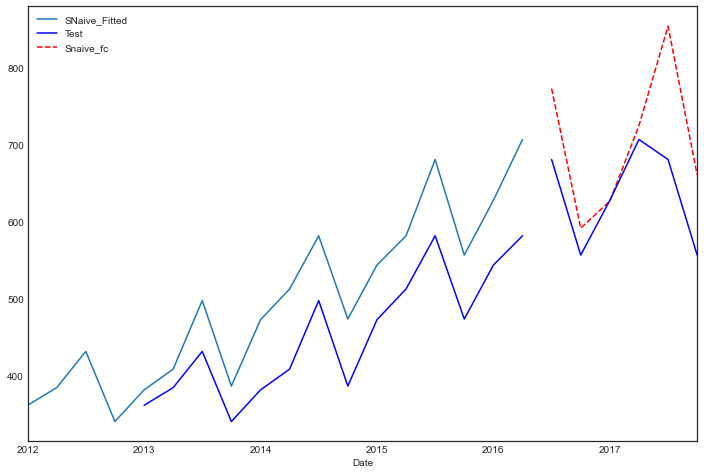

In [17]:
pd.plotting.register_matplotlib_converters()
train["Sales"].plot(figsize=(12,8))#, style="--", color="gray", legend=True, label="Train")
py_snaive_fit.plot(color="b", legend=True, label="SNaive_Fitted")
predictions["Sales"].plot(style="--",color="r", legend=True, label="Test")
predictions["py_snaive"].plot(color="b", legend=True, label="Snaive_fc");

In [18]:
#Training score - model evaluation
accuracy(train["Sales"].iloc[-len(py_snaive_fit.dropna()):], py_snaive_fit.dropna())

,%MAPE,RMSE
0,13.9,80.3


In [19]:
#Test score - model accuracy
accuracy(predictions["Sales"], predictions["py_snaive"])

,%MAPE,RMSE
0,9.4,92.0


C:\Users\seong\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


** Mean of the residuals:  75.21

** Ljung Box Test, p-value: 0.339 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.721 (>0.05, Normal)

** AD Fuller, p_value: 0.071 (>0.05, Non-stationary)


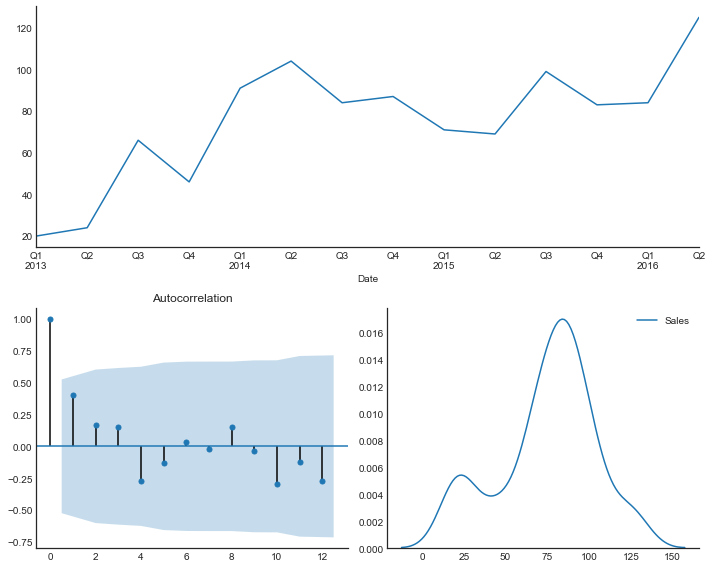

In [20]:
residcheck(py_snaive_resid.dropna(),12);

C:\Users\seong\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


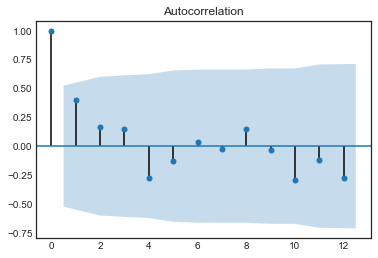

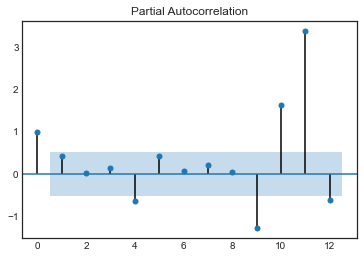

In [21]:
#PACF of Seasonal Snaive model residuals
plot_acf(py_snaive_resid);
plot_pacf(py_snaive_resid);

SMA의 문제점

1. 최근의 Shock(데이터의 충격 = 갑자기 크게 증폭하거나 감소하는 것)을 반영할 수 없다는 점

 

2. Sample Period(Window)를 얼마로 해야되는지 의문

 

3. 특정 시점이 Sample에 들어가는 지에 의해 굉장히 다른 값이 나옴(특정시점에 따라 변동성이 심각하게 달라짐)

 

4. 변동성 Clustering 효과를 잡아줄 수 없다 (변동성은 결코 시간에 대한 독립은 아니기 때문에)

## 지수가중이동평균[EWMA: The_Exponentially_Weighted_Moving_Average] 시계열 평활 방법 
: 작고 큰 아웃라이어의 영향을 줄임.  

* 시퀀스(Sequence)데이터
* 가중치 부여(옛 것 낮게) : 가중치는 e 도출


λ(0< λ <1)는 smoothing coefficient라고 부르며 값이 클수록 최근 시점값에 가중치를 높게 부여한다는 의미이다. 통상적으로 λ는 0.05 ~ 0.3 사이의 값을 가진다. 데이터의 변동이 클수록 λ값이 높아야 변화를 잘 잡아낼 수 있다. 반대로 데이터의 변동이 크지 않을 경우 λ의 값이 작을 수록 좋다. 만약 λ가 1이라면 b=0가 되고 C는 Identity Matrix가되어 x만 남게 된다

smoothing coefficient 구하는 공식에따라 구함.

In [ ]:
#pandas : 자동 smoothing coefficient
ewma_data = train_data.ewm(span=4).mean()

In [ ]:
 
df = pd.read_csv(path, index_col = 'Month', parse_dates=True)
df.dropna(inplace=True)
 
df.index #DatetimeIndex의 freq=None임 -> 지금 datetimeIndex가 freq가 없기에 설정을 해줌
df.index.freq= 'MS'
df.index
 
# from statsmodels.tsa.holtwinters import SimpleExpSmoothing
 
span = 12 #데이터의 freq가 월별 1년 기준이기 때문에 12로 설정
alpha = 2/(span+1) #여기서 alpha는 아래 그림 설명대로 설정해 준 것(span이 1을 넘기 때문에)
 
df['EWMA'] = df['Thousands of Passengers'].ewm(alpha = alpha, adjust=False).mean()
df['SES12'] = SimpleExpSmoothing(df['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
df.head() #여기서 참고로 'EWMA'와 'SES'로 구한 결과값은 같다
</code>

In [ ]:
<code>#%% Double Exponential Smoothing
 
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
 
df['DESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='add').fit().fittedvalues.shift(-1)
#여기서 Trend변수에 'add'를 설정할 경우 트랜드가 직선으로 증가 혹은 감소한다는 것을 나타냄
 
df['DESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)
#여기서 Trend변수에 'mul'를 설정할 경우 트랜드가 지수적으로 증가 혹은 감소한다는 것을 나타냄
 
df[['Thousands of Passengers',  'SES12', 'DESadd12','DESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True)
 
 
df[['Thousands of Passengers',  'SES12', 'DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True)
</code>

## 홀트 윈터 : 추세 + 계저성

1. additive= (Level + Trend) + Seasonality : 선형 트렌드
2. mutiplicative = (Level x Trend : %) Seasonality : 비선형 트렌드


* Level, (alpha): Average value around which the series varies. For a seasonal time series, level is obtained by first de-seasonalizing the series and then averaging. Alpha value determines how much of the past to consider and is between [0,1]. alpha=1 means give importance only to the last data point (naive forecast)
* Trend, (beta): Trend is how the level changes over time. Similar to alpha, a beta value closer to 1 indicates the model is considering only the recent trend. Trend also has a damping factor (phi) which determines how much of the recent trend to 'forget'. Consider it as a de-rating factor on trend.
* Seasonality (gamma): This factor models how the series behaves in each time period for full season. Recall that in the previous blog about EDA (Part 1), I calculated the seasonal factors. Gamma is the same thing.

In [24]:
m=HWGrid(train["Sales"], test["Sales"], seasonal_periods=4)
m

C:\Users\seong\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
C:\Users\seong\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",
C:\Users\seong\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


,Trend,Seasonal,Damped,BoxCox,AICc Train,%MAPE_Train,RMSE_Train,%MAPE_Test,RMSE_Test,Resid_LJ,Resid_Norm,Resid_mean
3,add,add,True,False,170.600000,3.55%,20.400000,10.79%,81.300000,Uncorrelated,Normal,4.400000
0,add,add,False,False,151.800000,2.41%,18.200000,10.98%,82.600000,Uncorrelated,Normal,4.900000
8,add,mul,False,log,139.700000,2.29%,13.000000,11.49%,84.000000,Uncorrelated,Normal,0.800000
11,add,mul,True,log,154.300000,2.29%,13.000000,11.49%,84.000000,Uncorrelated,Normal,0.800000
2,add,add,False,log,138.900000,2.20%,12.700000,11.69%,84.800000,Uncorrelated,Normal,0.800000
5,add,add,True,log,153.400000,2.20%,12.700000,11.69%,84.800000,Uncorrelated,Normal,0.800000
18,mul,mul,False,False,137.600000,2.31%,12.200000,11.88%,86.700000,Uncorrelated,Normal,-0.600000
12,mul,add,False,False,154.700000,3.09%,19.700000,12.09%,91.100000,Uncorrelated,Normal,5.800000
15,mul,add,True,False,170.500000,3.56%,20.400000,12.15%,91.400000,Uncorrelated,Normal,3.200000
23,mul,mul,True,log,153.400000,2.32%,12.700000,12.52%,92.100000,Uncorrelated,Normal,0.800000


In [25]:
hw_model = ExponentialSmoothing(train["Sales"],
                          trend    ="add",
                          seasonal = "add", 
                          seasonal_periods=4, 
                          damped=False).fit(use_boxcox='log')

hw_fitted = hw_model.fittedvalues

hw_resid = hw_model.resid

#Adding the mean of the residuals to correct the bias.
py_hw = hw_model.forecast(len(test["Sales"])) + np.mean(hw_resid)

predictions["py_hw"] = py_hw

#Holt-Winter Parameters
hw_model.params_formatted

,name,param,optimized
smoothing_level,alpha,7.538756e-01,True
smoothing_slope,beta,3.614297e-09,True
smoothing_seasonal,gamma,0.000000e+00,True
initial_level,l.0,6.094554e+00,True
initial_slope,b.0,3.675576e-02,True
initial_seasons.0,s.0,-2.462860e-01,True
initial_seasons.1,s.1,-2.036242e-01,True
initial_seasons.2,s.2,-9.366448e-02,True
initial_seasons.3,s.3,-3.541633e-01,True


Note the optimized alpha, beta and gamma parameters.

alpha: 0.75, i.e 75% weight was given to the last observation

beta: learning parameter for trend. very small. Not much weight is given to the recent trend and trend is obatained from distant past

gamma: seasonal factor is 0. gamma is usually very small (<0.2) and we want it to be small. If the gamma is high, it can lead to overfitting becuase it means the model is learning too much from recent the recenet data. 0 here indicates seasonality is learned from the earliest season.

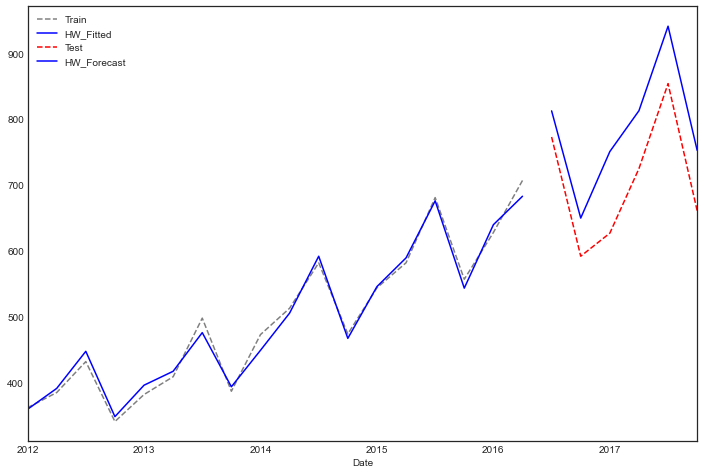

In [26]:
#Plotting

train["Sales"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
hw_fitted.plot(color="b", legend=True, label="HW_Fitted")
predictions["Sales"].plot(style="--",color="r", legend=True, label="Test")
predictions["py_hw"].plot(color="b", legend=True, label="HW_Forecast");

In [ ]:
<code>  #%% Triple Exponential Smoothing
 
df['TESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
 
df['TESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
 
df[['Thousands of Passengers','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True)
</code>

In [ ]:
<code>
df = pd.read_csv(path, index_col = 'Month', parse_dates=True)
df.index.freq = 'MS'
df.head()
df.info()
 
#%% Train 및 Test 기간 나누기
 
train_data = df.iloc[:108] # iloc의 경우 인덱스 번호 기준으로 지정을 하는거고, 만약 Date로 할 경우 df.loc[:'2012-01-01']으로 지정
test_data = df.iloc[108:]
 
#%% Fitting Parameters
 
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
 
fitted_model = ExponentialSmoothing(train_data['Thousands of Passengers'], trend='mul',seasonal='mul',seasonal_periods=12).fit()
 
#%% Forecasting
 
test_predictions = fitted_model.forecast(36).rename('HW Forecast')
 
train_data['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_data['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION')
 
#%%
 
train_data['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_data['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION',xlim=['1958-01-01','1961-01-01'])
</code>

# cross-validation

데이터 길이가 짧을때 overrfit 하지 않도록

1. Expanding window cross-validation:
2. Rolling Window cross-validation:

In [27]:
#I would like to perform 5 fold cross validation, want the training size to be at 
#least 12 and test window = forecast horizon 24 - 4 - 5 = 15. Initial training size should be min 12, max 15. 
#I will choose 15

hw_cv(data["Sales"], seasonal_periods=4, initial_train_window=15, test_window=4)

add add False False    R: 39.2   ,E: 41.3
add add False True    R: 43.4   ,E: 51.0
add add False log    R: 41.2   ,E: 37.1
add add True False    R: 40.5   ,E: 45.9
add add True True    R: 38.7   ,E: 45.5
add add True log    R: 34.7   ,E: 39.1
add mul False False    R: 35.3   ,E: 40.3
add mul False True    R: 42.3   ,E: 50.4
add mul False log    R: 44.0   ,E: 40.7
add mul True False    R: 38.8   ,E: 40.8
add mul True True    R: 36.8   ,E: 45.6
add mul True log    R: 37.1   ,E: 41.5
mul add False False    R: 47.8   ,E: 43.8
mul add False True    R: 47.7   ,E: 49.7
mul add False log    R: 45.2   ,E: 39.1
mul add True False    R: 163.9   ,E: 90.7
mul add True True    R: 220.9   ,E: 70.1
mul add True log    R: 530.8   ,E: 39.1
mul mul False False    R: 42.9   ,E: 38.9
mul mul False True    R: 49.1   ,E: 52.3
mul mul False log    R: 42.7   ,E: 39.2
mul mul True False    R: 79.2   ,E: nan
mul mul True True    R: nan   ,E: 71.2
mul mul True log    R: 1841.8   ,E: 39.9


** Mean of the residuals:  0.84

** Ljung Box Test, p-value: 0.3 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.419 (>0.05, Normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


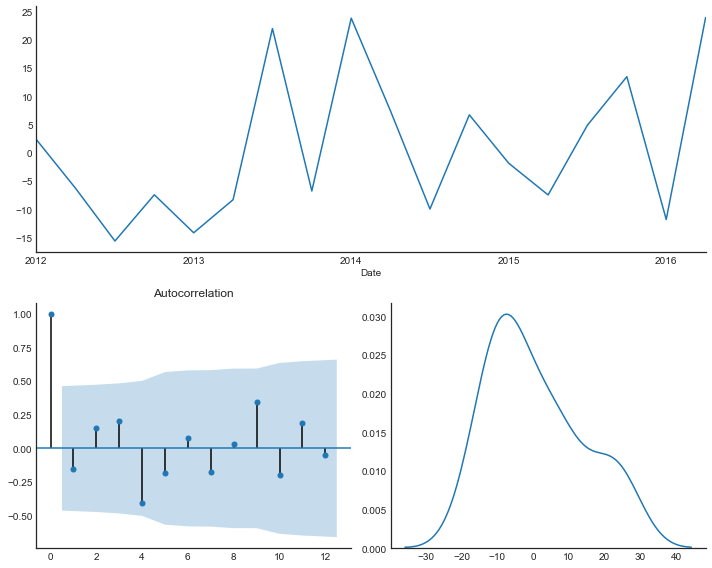

In [28]:
residcheck(hw_resid, 12);

In [29]:
accuracy(predictions.Sales,predictions["py_hw"] )

,%MAPE,RMSE
0,11.8,85.7


ETS 모델(error, trend, seasonal)



* X:Error (aka innovations). It can be Additive (A) or Multiplicative (M)
* Y:Trend. Trend component can be No trend (N), additive (A), Multiplicative (M) or damped (Ad)
* Z:Seasonality, Null (N), additive (A) or multiplicative (M)


![](https://ko.logpresso.com/api/documents/19/sections/113/images/image150.png)

In [ ]:
<code>  airline = pd.read_csv(path, index_col = 'Month', parse_dates=True)
 
airline = airline.dropna()
 
airline.plot()
 
from statsmodels.tsa.seasonal import seasonal_decompose
 
result = seasonal_decompose(airline['Thousands of Passengers'], model = 'multiplicative')
 
result.trend
 
result.seasonal
 
result.plot()
</code>

## ETS(A,Ad,A) model with Log

In [31]:
#https://www.statsmodels.org/stable/statespace.html#
ets_LAdA=sm.tsa.statespace.ExponentialSmoothing(train_log,
                                           trend=True, 
                                           initialization_method= 'heuristic', 
                                           seasonal=4, 
                                           damped_trend=True).fit()

fc_LAdA = np.exp(ets_LAdA.forecast(6)) #inverting the Log

predictions["LAdA"]=fc_LAdA

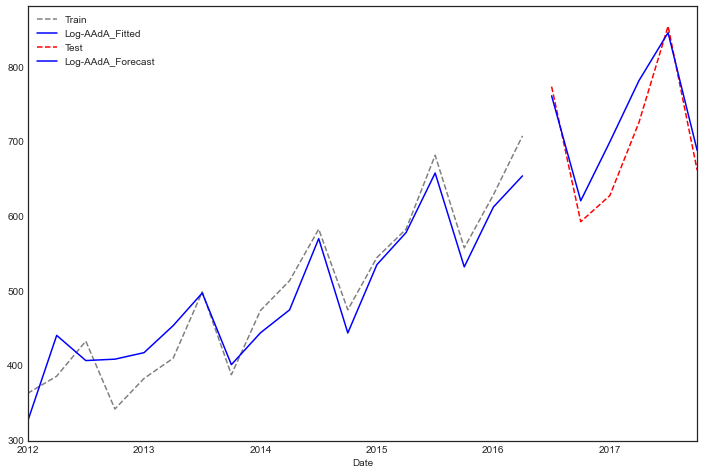

In [32]:
#Plotting

train["Sales"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
np.exp(ets_LAdA.fittedvalues).plot(color="b", legend=True, label="Log-AAdA_Fitted")
predictions["Sales"].plot(style="--",color="r", legend=True, label="Test")
predictions["LAdA"].plot(color="b", legend=True, label="Log-AAdA_Forecast");

In [33]:
accuracy(predictions["Sales"],predictions["LAdA"])

,%MAPE,RMSE
0,5.1,40.9


** Mean of the residuals:  0.0

** Ljung Box Test, p-value: 0.346 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.266 (>0.05, Normal)

** AD Fuller, p_value: 0.712 (>0.05, Non-stationary)


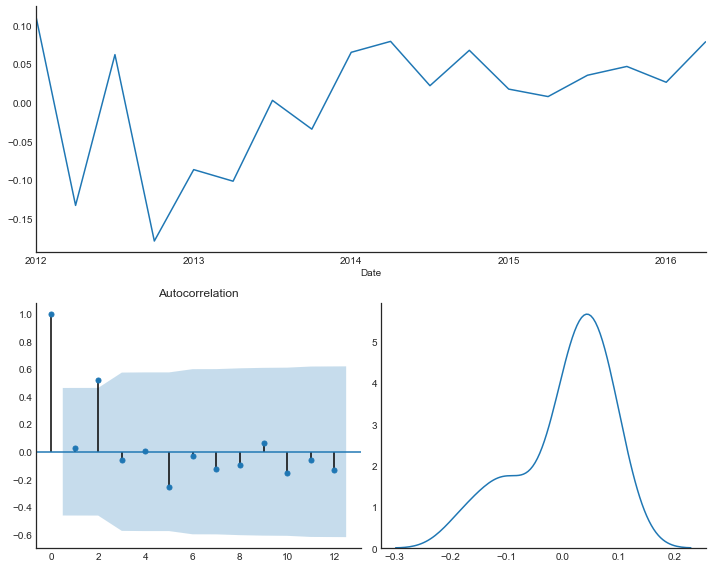

In [34]:
residcheck(ets_LAdA.resid,12);

In [35]:
# ETS(A,Ad,A)
ets_AAdA=sm.tsa.statespace.ExponentialSmoothing(train,
                                           trend=True, 
                                           initialization_method= 'concentrated', 
                                           seasonal=4, 
                                           damped_trend=True).fit()

fc_AAdA=ets_AAdA.forecast(len(test))

predictions["AAdA"]=fc_AAdA

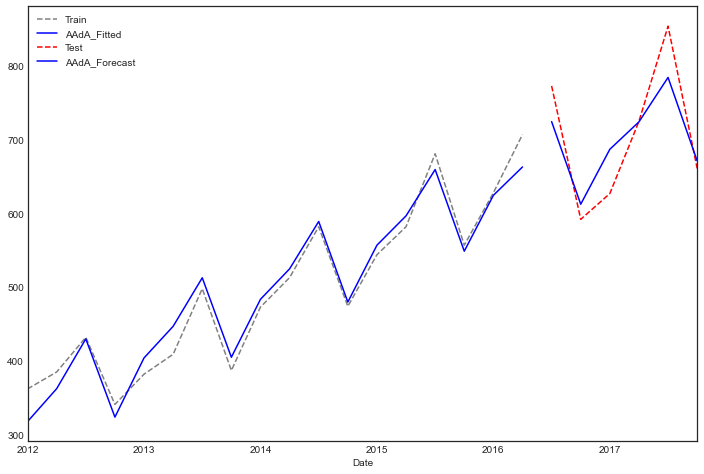

In [36]:
#Plotting

train["Sales"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
ets_AAdA.fittedvalues.plot(color="b", legend=True, label="AAdA_Fitted")
predictions["Sales"].plot(style="--",color="r", legend=True, label="Test")
predictions["AAdA"].plot(color="b", legend=True, label="AAdA_Forecast");

In [37]:
accuracy(predictions["Sales"],predictions["AAdA"])

,%MAPE,RMSE
0,4.9,43.4


** Mean of the residuals:  0.4

** Ljung Box Test, p-value: 0.165 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.582 (>0.05, Normal)

** AD Fuller, p_value: 1.0 (>0.05, Non-stationary)


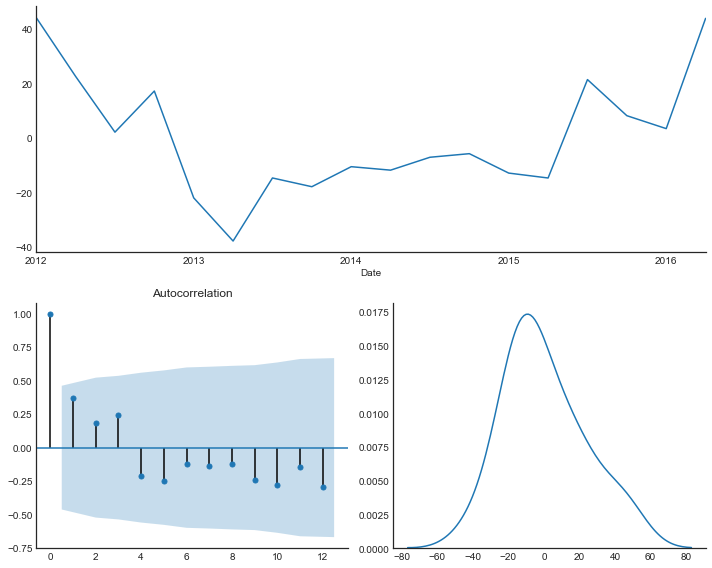

In [38]:
residcheck(ets_AAdA.resid,12);

## SARIMA (Seasonal, Auto-Regressive, Integrated, Moving Average Model)

### Auto-regression, AR(p):
1. As the name suggests, it's the linear regression with its past values
2. AR (p) => Current value = mean + fraction (phi) of yesterday's value + fraction (phi) of day before yesterday's value +......+ fraction of pth day's value + noise
3. If phi is negaitive => mean inversion, i.e today's value will likely go down after yesterday's peak.
4. If phi is positive => Momentum
5. If phi = 0 => white noise
6. If phi = 1 => random walk
7. phi has to be between [-1,1] for process to be stationary
8. If the PACF plot cuts off sharply at lag k, while there is a gradual decay in ACF, it's a AR(p) process. [Note: I keep PACF and AR(P) mnemonic in mind to know which plot to use for identifying AR process)
9. An AR(1) model is equivalent to MA(infinity) model, (practially q>>50)

### Moving Average ,MA(q):
1. MA process is not the same as taking moving average of a series
2. MA process is made up of white noise at different times. In MA(q), q tells us how far back along the sequence of white noise we have to loo for weighted average
3. For example, in our case if the series is an MA(q) process, the forecast is not affected by the previous sales but rather errors in past forecast.
4. MA processes are not common but when combined with AR, can produce very accurate forecasts
5. For an MA(q) model, the forecast beyond 1 period will be the same for rest of the forecast horizon
6. To identify MA(q) process, plot the ACF. If it sharply cuts off at qth lag, it's an MA(q) process

ARIMA (p,d,q) = constant + (weighted sum of last p values) + (weighted sum of last q values of forecast errors) after d differencing

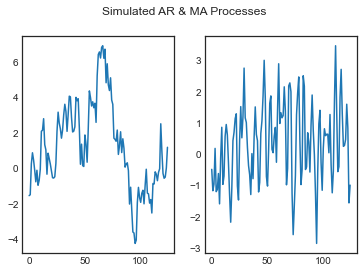

In [39]:
#Simulating AR process
from statsmodels.tsa.arima_process import ArmaProcess
ar = np.array([1,-0.9])
ma = np.array([1, 0.9])
AR = ArmaProcess(ar=ar, ma=None)
MA = ArmaProcess(ar=None, ma=ma)
simulated_AR= AR.generate_sample(125)
simulated_MA= MA.generate_sample(125)


fig, (ax1, ax2) = plt.subplots(1, 2)
# fig = plt.figure(figsize=(10,8))
fig.suptitle('Simulated AR & MA Processes')
ax1.plot(simulated_AR);
ax2.plot(simulated_MA);

Finding the parameters of the ARIMA process (p,d,q) is an art and science. Generally, p+q <=3. Similar to ARIMA, Seasonal ARIMA (SARIMA) has (P,D,Q) parameters, so SARIMA is (p,d,q)(P,D,Q). p+d+q+P+D+Q <=6 (generally)

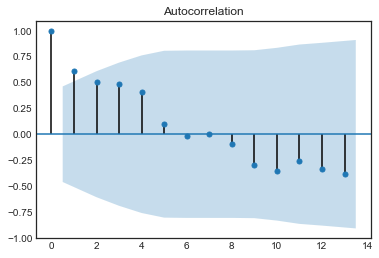

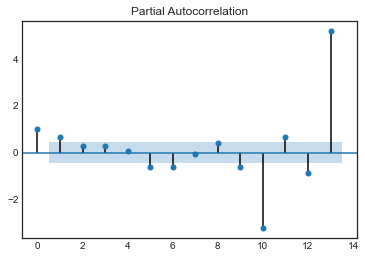

In [40]:
plot_acf(train["Sales"]);
plot_pacf(train["Sales"]);

In [41]:
(auto_arima(train["Sales"],
           seasonal=True,
           m=4,                          #seasonality_order 4
           d=1,                          #ACF plot showed we need at least 1 differencing
           information_criterion='aicc'). #You can choose AIC, BIC. AICc is corrected AIC
           summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   18
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 4)   Log Likelihood                 -58.474
Date:                           Wed, 17 Feb 2021   AIC                            120.948
Time:                                   15:05:12   BIC                            122.078
Sample:                                        0   HQIC                           120.716
                                            - 18                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L4       -0.6502      0.373     -1.744      0.081      -1.381       0.081
sigma2       399.4280    246.415      1.621      0.105     -83.537     882.393
===================================================================================
Ljung-Box (Q):                       15.54   Jarque-Bera (JB):                 0.76
Prob(Q):                              0.21   Prob(JB):                         0.68
Heteroskedasticity (H):               0.89   Skew:                             0.21
Prob(H) (two-sided):                  0.91   Kurtosis:                         1.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

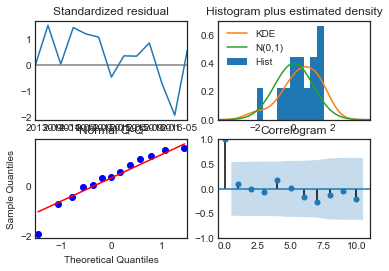

In [42]:
#Creating SARIMA model in Python using statsmodels

sarima_model=(SARIMAX(endog=train["Sales"], 
               order=(0,1,1),
               seasonal_order=(1,1,0,4),
               trend='c',
               enforce_invertibility=False))

sarima_fit=sarima_model.fit()

start = len(train)
end = len(train) +len(test) -1

sarima_fitted = sarima_fit.fittedvalues

sarima_resid = sarima_fit.resid

py_sarima = sarima_fit.predict(start, end, dynamic=False)

predictions["py_sarima"] = py_sarima

sarima_fit.plot_diagnostics();

In [43]:
accuracy(predictions.Sales,py_sarima)

,%MAPE,RMSE
0,12.6,94.4


In [44]:
#Fitting model to log of train

(auto_arima(np.log(train["Sales"]),
           seasonal=True,
           m=4,                           #seasonality_order 4
           information_criterion='aicc'). #You can choose AIC, BIC. AICc is corrected AIC
           summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                       y   No. Observations:                   18
Model:             SARIMAX(1, 1, 0, 4)   Log Likelihood                  26.993
Date:                 Wed, 17 Feb 2021   AIC                            -47.986
Time:                         15:06:53   BIC                            -46.068
Sample:                              0   HQIC                           -48.163
                                  - 18                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2848      0.032      8.946      0.000       0.222       0.347
ar.S.L4       -0.8100      0.164     -4.943      0.000      -1.131      -0.489
sigma2         0.0009      0.001      1.356      0.175      -0.000       0.002
===================================================================================
Ljung-Box (Q):                       20.25   Jarque-Bera (JB):                 0.47
Prob(Q):                              0.09   Prob(JB):                         0.79
Heteroskedasticity (H):               0.40   Skew:                            -0.24
Prob(H) (two-sided):                  0.34   Kurtosis:                         2.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
sarima_logmodel=(SARIMAX(np.log(train["Sales"]), 
               order=(0,0,0),
               seasonal_order=(1,1,0,4),
               trend='c',
               enforce_invertibility=False)).fit()

sarima_log = np.exp(sarima_logmodel.predict(start, end))

predictions["sarima_log"] = sarima_log

slog_fitted = np.exp(sarima_logmodel.fittedvalues)

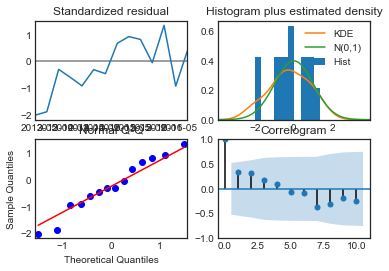

In [46]:
sarima_logmodel.plot_diagnostics();

In [47]:
accuracy(predictions.Sales,sarima_log )

,%MAPE,RMSE
0,11.1,81.7


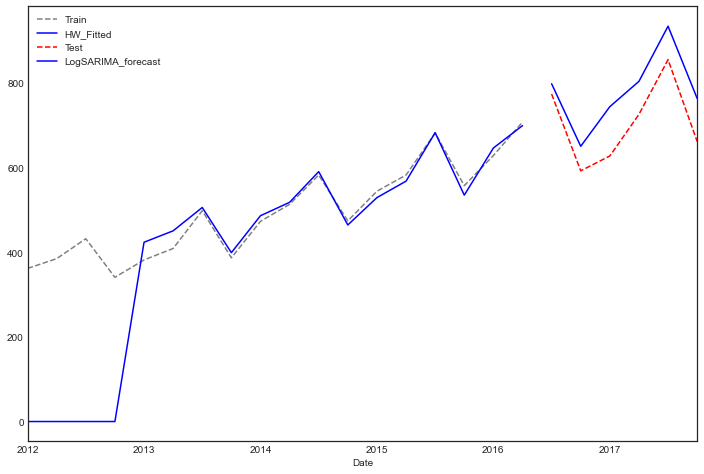

In [48]:
#Plotting

train["Sales"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
slog_fitted.plot(color="b", legend=True, label="HW_Fitted")
predictions["Sales"].plot(style="--",color="r", legend=True, label="Test")
predictions["sarima_log"].plot(color="b", legend=True, label="LogSARIMA_forecast");

## Prophet : curve fitting

1. 추세
    1. piecewise logistic growth : 비선형, 변환점 반영.
    2. piecewise constant rate of  growth : 선형 , 
2. 계절성
    1. prophet use Fourier esries
    2. P = 계절주기
3. 휴일 효과(h)
    1. 목록의 생성
    
    
" Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well."

In [11]:
from fbprophet import Prophet

data_fb = data.reset_index()
data_fb.columns=['ds','y']   #create new df with columns ds & y
train_fb, test_fb = data_fb.iloc[:-len(test)], data_fb.iloc[-len(test):]   #create train & test df

In [13]:
print('0')
#Fit the model to train
fb1_pro_df=Prophet(weekly_seasonality=False,
           daily_seasonality=False, 
           n_changepoints=10, 
           seasonality_mode="multiplicative") 

fb1_model = fb1_pro_df.fit(train_fb)          
#I tried "additive too", it was slightly worse 

#Prophet results are saved to a dataframe using make_future_dataframe()
fb1_df=fb1_model.make_future_dataframe(6, freq='Q') #set the freq argument to 'Q' for quarterly data
#We only need "ds" and "yhat" columns.. "ds" is the date column and "yhat" are predictions

fb1_fc_df=fb1_model.predict(fb1_df)[["ds","yhat"]]

fb1_fc__=fb1_model.predict(fb1_df)
#Residuals
fb1_resid = train["Sales"].values - fb1_fc_df['yhat'].iloc[:len(train)]
fb1_fc = fb1_fc_df.iloc[-len(test):]

predictions["fb1"] = fb1_fc["yhat"].values

0


AttributeError: 'StanModel' object has no attribute 'fit_class'

In [1]:
fb1_fc_df.head()

NameError: name 'fb1_fc_df' is not defined

In [12]:
# In Python
import pystan
print(pystan.__version__)

2.19.0.0
